In [44]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder
from sklearn.metrics import confusion_matrix, f1_score

In [4]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # Data Augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomAffine(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


In [5]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 128

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("Downloads/archive/training", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("Downloads/archive/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
test_set = DatasetFolder("Downloads/archive/evaluation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [14]:
def visualize_images(dataloader):
    figure, ax = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))
    classes = list(dataloader.dataset.class_to_idx.keys())
    img_no = 0
    for images, labels in dataloader:
        for i in range(5):
            for j in range(5):
                img = np.array(images[img_no]).transpose(1,2,0)
                lbl = labels[img_no]

                ax[i, j].imshow(img)
                ax[i, j].set_title(classes[lbl])
                ax[i, j].set_axis_off()
                img_no += 1
        break
    figure.tight_layout()

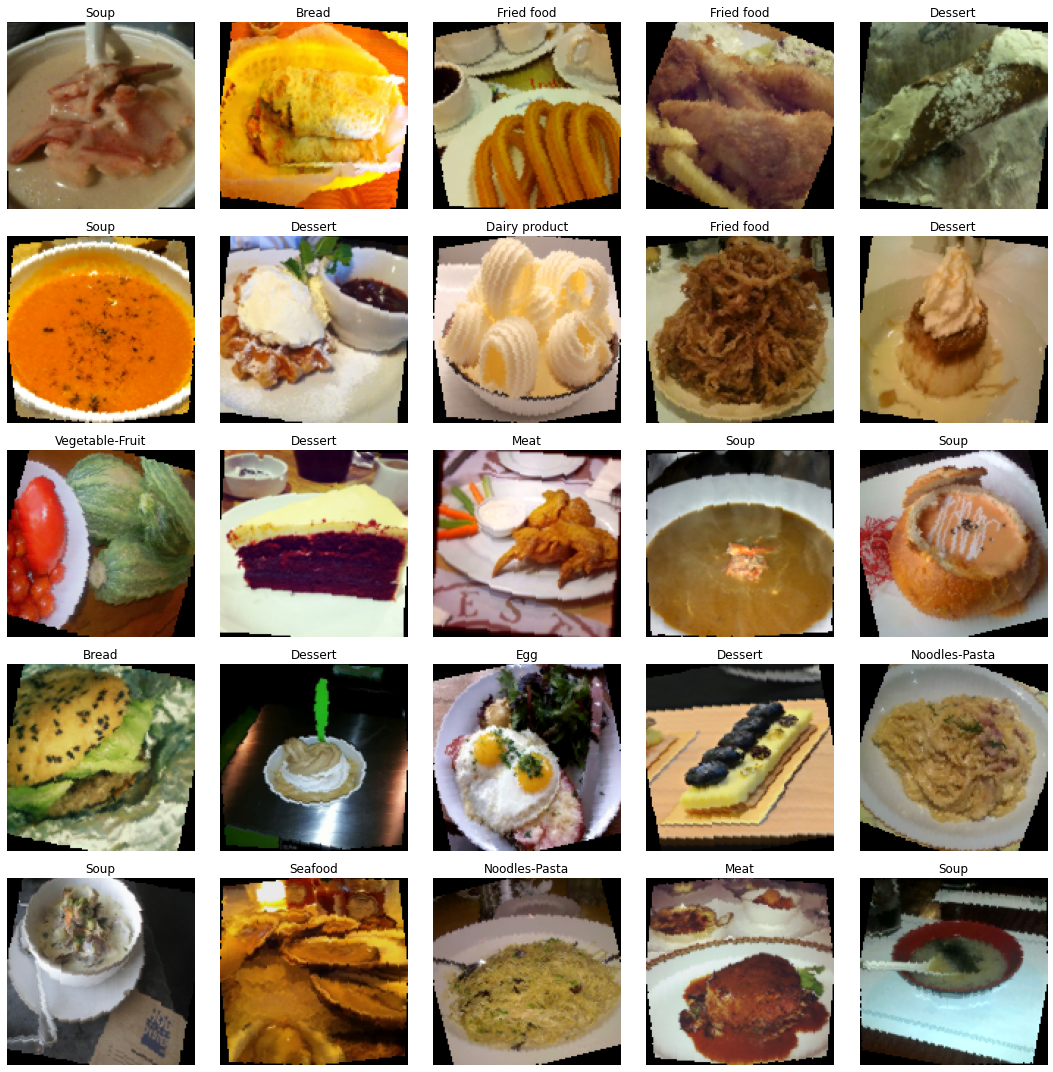

In [24]:
visualize_images(train_loader)

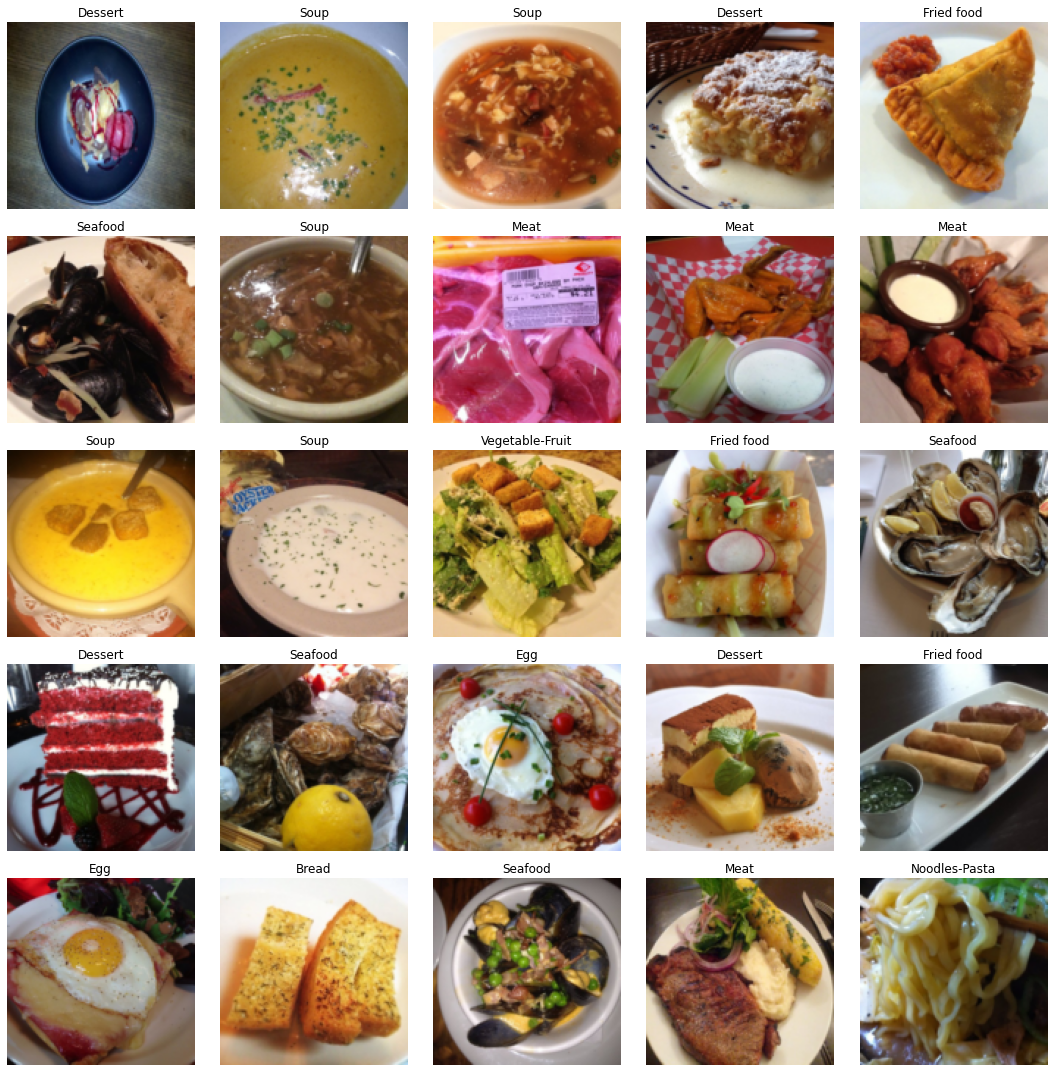

In [15]:
visualize_images(valid_loader)

In [25]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 128, 128]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 11)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [26]:
learning_rate = 3e-3
weight_decay = 1e-5
n_epochs = 20

In [27]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"
    
# Initialize a model, and put it on the device specified.
model = Classifier().to(device)
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

history = []

for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    # Record
    result = {}
    result["train_loss"] = train_loss
    result["train_acc"] = train_acc
    result["valid_acc"] = valid_acc
    history.append(result)

  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 001/020 ] loss = 5.95445, acc = 0.19543


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 001/020 ] loss = 2.11658, acc = 0.25517


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 002/020 ] loss = 1.92883, acc = 0.31967


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 002/020 ] loss = 2.13489, acc = 0.27080


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 003/020 ] loss = 1.80111, acc = 0.36801


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 003/020 ] loss = 1.94177, acc = 0.31609


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 004/020 ] loss = 1.72027, acc = 0.39864


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 004/020 ] loss = 1.71705, acc = 0.40074


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 005/020 ] loss = 1.63832, acc = 0.42935


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 005/020 ] loss = 1.64143, acc = 0.42671


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 006/020 ] loss = 1.53607, acc = 0.46306


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 006/020 ] loss = 1.75119, acc = 0.41470


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 007/020 ] loss = 1.46003, acc = 0.48894


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 007/020 ] loss = 1.56329, acc = 0.46195


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 008/020 ] loss = 1.44006, acc = 0.49461


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 008/020 ] loss = 1.58011, acc = 0.45340


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 009/020 ] loss = 1.36963, acc = 0.51274


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 009/020 ] loss = 1.61024, acc = 0.47373


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 010/020 ] loss = 1.31175, acc = 0.54147


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 010/020 ] loss = 1.48460, acc = 0.50774


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 011/020 ] loss = 1.27647, acc = 0.55923


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 011/020 ] loss = 1.80507, acc = 0.45977


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 012/020 ] loss = 1.21687, acc = 0.57694


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 012/020 ] loss = 1.67819, acc = 0.44291


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 013/020 ] loss = 1.15191, acc = 0.60687


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 013/020 ] loss = 1.84453, acc = 0.39755


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 014/020 ] loss = 1.14027, acc = 0.60387


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 014/020 ] loss = 1.54265, acc = 0.49559


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 015/020 ] loss = 1.10866, acc = 0.61438


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 015/020 ] loss = 1.40134, acc = 0.55114


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 016/020 ] loss = 1.04570, acc = 0.63468


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 016/020 ] loss = 1.45207, acc = 0.52366


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 017/020 ] loss = 1.03147, acc = 0.64279


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 017/020 ] loss = 2.00394, acc = 0.42151


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 018/020 ] loss = 1.01659, acc = 0.64607


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 018/020 ] loss = 1.81764, acc = 0.45543


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 019/020 ] loss = 0.97496, acc = 0.66372


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 019/020 ] loss = 1.72327, acc = 0.51601


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 020/020 ] loss = 0.94597, acc = 0.67400


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 020/020 ] loss = 1.37079, acc = 0.56975


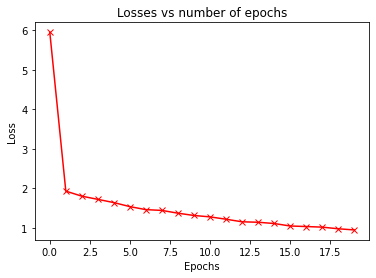

In [29]:
# print(history)
loss = [x["train_loss"] for x in history]
plt.plot(loss, "-rx")
plt.title("Losses vs number of epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("report_AI/train_loss_cnn_20.png")

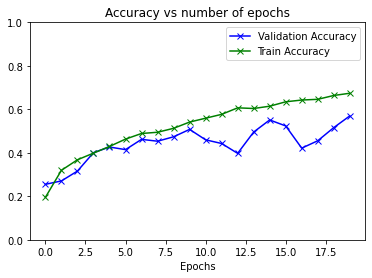

In [42]:
valid_acc = [x["valid_acc"].item() for x in history]
train_acc = [x["train_acc"].item() for x in history]
plt.ylim([0, 1])
plt.plot(valid_acc, "-bx")
plt.plot(train_acc, "-gx")
plt.title("Accuracy vs number of epochs")
plt.legend(["Validation Accuracy", "Train Accuracy"])
plt.xlabel("Epochs")
plt.savefig("report_AI/accuracy_cnn_20.png")

In [31]:
class_names = {
    0: 'Bread', 
    1: 'Dairy product', 
    2: 'Dessert', 
    3: 'Egg', 
    4: 'Fried food', 
    5: 'Meat',
    6: 'Noodles-Pasta',
    7: 'Rice', 
    8: 'Seafood',
    9: 'Soup',
    10: 'Vegetable-Fruit'
}

In [32]:
# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

# Initialize a list to store the predictions.
y_pred = []
y_true = []
test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = model(imgs.to(device))
    
    # Compute and record the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
    test_accs.append(acc)
    
    # Take the class with greatest logit as prediction and record it.
    y_pred.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    y_true.extend(labels.view(-1).cpu().numpy())
    # print(len(labels))
    
test_acc = sum(test_accs) / len(test_accs)    

  0%|          | 0/27 [00:00<?, ?it/s]

In [46]:
acc = 0
for i in range(len(y_true)):
    if y_pred[i] == y_true[i]:
        acc += 1
acc = acc / len(y_true)
print(acc)
print(f"{test_acc:.5f}")

# Calculate f1-score
f1 = f1_score(y_true, y_pred, average='micro')
print(f"F1-Score: {f1:.4f}")

0.5858978189423364
0.59232
F1-Score: 0.5859


{0: 'Bread', 1: 'Dairy product', 2: 'Dessert', 3: 'Egg', 4: 'Fried food', 5: 'Meat', 6: 'Noodles-Pasta', 7: 'Rice', 8: 'Seafood', 9: 'Soup', 10: 'Vegetable-Fruit'}
[0.39631336 0.88       0.71966527 0.64021164 0.59744409 0.62598425
 0.63492063 0.23174603 0.4877551  0.79241517 0.86956522]
Plot confusion matrix


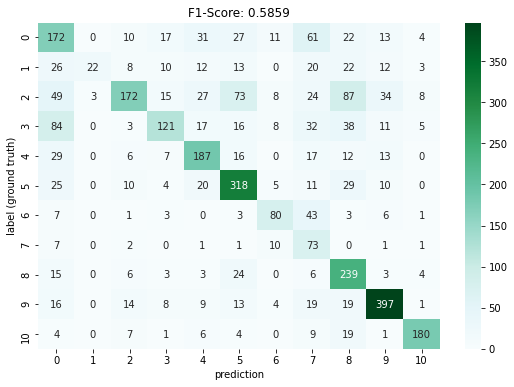

In [47]:
# 製作混淆矩陣
cf_matrix = confusion_matrix(y_true, y_pred)   

# 計算每個class的accuracy
per_cls_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=0)
print(class_names)
print(per_cls_acc)
print("Plot confusion matrix")

# 開始繪製混淆矩陣並存檔
df_cm = pd.DataFrame(cf_matrix, class_names, class_names) 
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')

plt.title(f"F1-Score: {f1:.4f}")
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig("report_AI/confusion_matrix_cnn_20.png")

In [37]:
model_name = 'cnn_20.pt'
torch.save(model, model_name)